```Importing necessary Libraries```

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pickle

In [ ]:
df = pd.read_csv('train.csv')

In [ ]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


## Features:
- **ApplicantIncome**: Monthly income of the applicant.
- **CoapplicantIncome**: Monthly income of the co-applicant.
- **LoanAmount**: Requested loan amount.
- **Loan_Amount_Term**: Loan repayment term (in months).
- **Credit_History**: 1 if the applicant has a good credit history, 0 otherwise.
- **Gender**: Male/Female.
- **Married**: Yes/No.
- **Dependents**: Number of dependents.
- **Education**: Graduate/Not Graduate.
- **Property_Area**: Urban/Rural/Semi-Urban.

## Target Variable:
- **Loan_Status**:
  - `1` (Approved)
  - `0` (Rejected)


In [ ]:
from collections import Counter
print(Counter(df['Loan_Status']))

Counter({'Y': 422, 'N': 192})


In [ ]:
df['LoanAmount'] = df['LoanAmount'].fillna(df['LoanAmount'].mean())

```Imputing necessary libraries```

In [ ]:
from sklearn.compose import ColumnTransformer

# Define the column names for categorical and numerical features
categorical_features_names = ['Gender','Dependents','Married','Self_Employed']
numerical_features_names = ['ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term','Credit_History']

# Create SimpleImputer objects for each type of feature
categorical_imputer = SimpleImputer(strategy='most_frequent')
numerical_imputer = SimpleImputer(strategy='most_frequent')

# Create the ColumnTransformer using the column names and imputers
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_imputer, categorical_features_names),
        ('num', numerical_imputer, numerical_features_names)
    ],
    remainder='passthrough'
)

# Apply the transformation
df_transformed = preprocessor.fit_transform(df)

# Reconstruct the DataFrame with appropriate column names
df = pd.DataFrame(df_transformed, columns=categorical_features_names + numerical_features_names + df.drop(categorical_features_names + numerical_features_names, axis=1).columns.tolist())

# Ensure correct data types for columns
for col in categorical_features_names + numerical_features_names:
    df[col] = df[col].astype(df[col].dtype)

In [ ]:
df.head()

,Gender,Dependents,Married,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_ID,Education,Property_Area,Loan_Status
0,Male,0,No,No,5849.0,0.0,146.412162,360.0,1.0,LP001002,Graduate,Urban,Y
1,Male,1,Yes,No,4583.0,1508.0,128.0,360.0,1.0,LP001003,Graduate,Rural,N
2,Male,0,Yes,Yes,3000.0,0.0,66.0,360.0,1.0,LP001005,Graduate,Urban,Y
3,Male,0,Yes,No,2583.0,2358.0,120.0,360.0,1.0,LP001006,Not Graduate,Urban,Y
4,Male,0,No,No,6000.0,0.0,141.0,360.0,1.0,LP001008,Graduate,Urban,Y


In [ ]:
# Convert the 'LoanAmount' column to a numeric data type
df['LoanAmount'] = pd.to_numeric(df['LoanAmount'], errors='coerce')

# Now apply the square root transformation, handling potential NaNs
df['LoanAmount'] = df['LoanAmount'].apply(lambda x: np.sqrt(x + 1) if pd.notna(x) else x)

# Similarly for 'ApplicantIncome'
df['ApplicantIncome'] = pd.to_numeric(df['ApplicantIncome'], errors='coerce')
df['ApplicantIncome'] = df['ApplicantIncome'].apply(lambda x: np.sqrt(x + 1) if pd.notna(x) else x)

```Handling outliers```

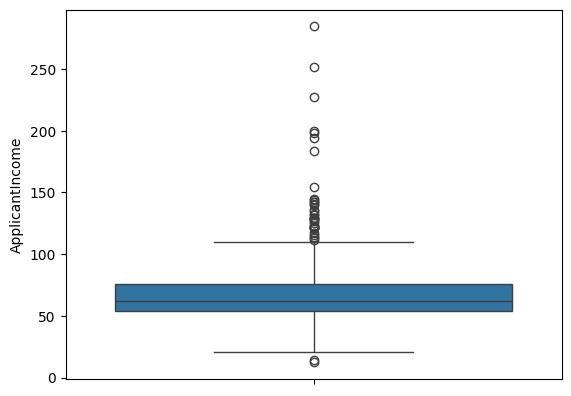

In [ ]:
sns.boxplot(df['ApplicantIncome'])
plt.show()

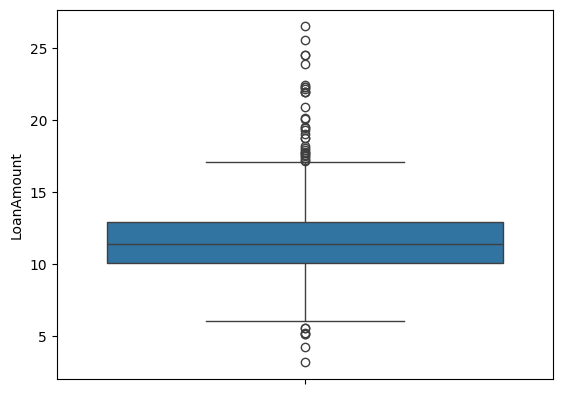

In [ ]:
sns.boxplot(df['LoanAmount'])
plt.show()

In [ ]:
df['LoanAmount'].skew()

1.324874689334041

In [ ]:
df['ApplicantIncome'].skew()

2.967692722896689

In [ ]:
df['LoanAmount'] = np.sqrt(df['LoanAmount'] + 1)  # Adding 1 to avoid issues with zeros
df['ApplicantIncome'] = np.sqrt(df['ApplicantIncome'] + 1)  # Adding 1 to avoid issues with zeros


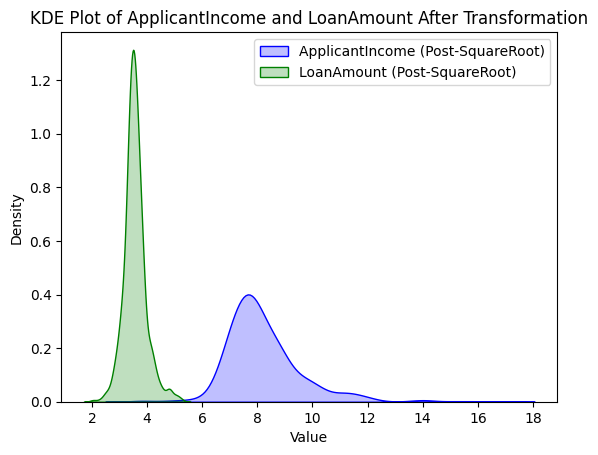

In [ ]:
# KDE Plot for both features after square root transformation
sns.kdeplot(df['ApplicantIncome'], shade=True, color="blue", label="ApplicantIncome (Post-SquareRoot)")
sns.kdeplot(df['LoanAmount'], shade=True, color="green", label="LoanAmount (Post-SquareRoot)")

plt.title('KDE Plot of ApplicantIncome and LoanAmount After Transformation')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()


In [ ]:
# Checking skewness after log transformation
print(f"Skewness of ApplicantIncome: {df['ApplicantIncome'].skew()}")
print(f"Skewness of LoanAmount: {df['LoanAmount'].skew()}")

Skewness of ApplicantIncome: 1.6985955295545343
Skewness of LoanAmount: 0.6664329219145295


```Scaling Numerical features```

In [ ]:
#Standard scaling for the numerical features
scaler = StandardScaler()
numerical_features = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

```Encoding categorical values```

In [ ]:
# Encoding Education to label encoding

Label_encoder = LabelEncoder()
df['Education'] = Label_encoder.fit_transform(df['Education'])
df['Loan_Status'] = Label_encoder.fit_transform(df['Loan_Status'])

In [ ]:
# One hotencoding for Gender & Property area
df = pd.get_dummies(df, columns=['Gender', 'Property_Area'], drop_first=True)

In [ ]:
# Convert 'Yes' and 'No' to 1 and 0 before using astype('Int64')
df['Married'] = df['Married'].map({'Yes': 1, 'No': 0}).astype('Int64')
df['Self_Employed'] = df['Self_Employed'].map({'Yes': 1, 'No': 0}).astype('Int64')

In [ ]:
# Convert True/False to 1/0 for One-Hot Encoded columns
df['Gender_Male'] = df['Gender_Male'].astype(int)
df['Property_Area_Semiurban'] = df['Property_Area_Semiurban'].astype(int)
df['Property_Area_Urban'] = df['Property_Area_Urban'].astype(int)

In [ ]:
df.head()

,Dependents,Married,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_ID,Education,Loan_Status,Gender_Male,Property_Area_Semiurban,Property_Area_Urban
0,0,0,0,0.417446,-0.554487,0.184944,0.273231,0.411733,LP001002,0,1,1,0,1
1,1,1,0,0.049986,-0.038732,-0.087761,0.273231,0.411733,LP001003,0,0,1,0,0
2,0,1,1,-0.536685,-0.554487,-1.292191,0.273231,0.411733,LP001005,0,1,1,0,1
3,0,1,0,-0.729227,0.251980,-0.215172,0.273231,0.411733,LP001006,1,1,1,0,1
4,0,0,0,0.457172,-0.554487,0.107497,0.273231,0.411733,LP001008,0,1,1,0,1


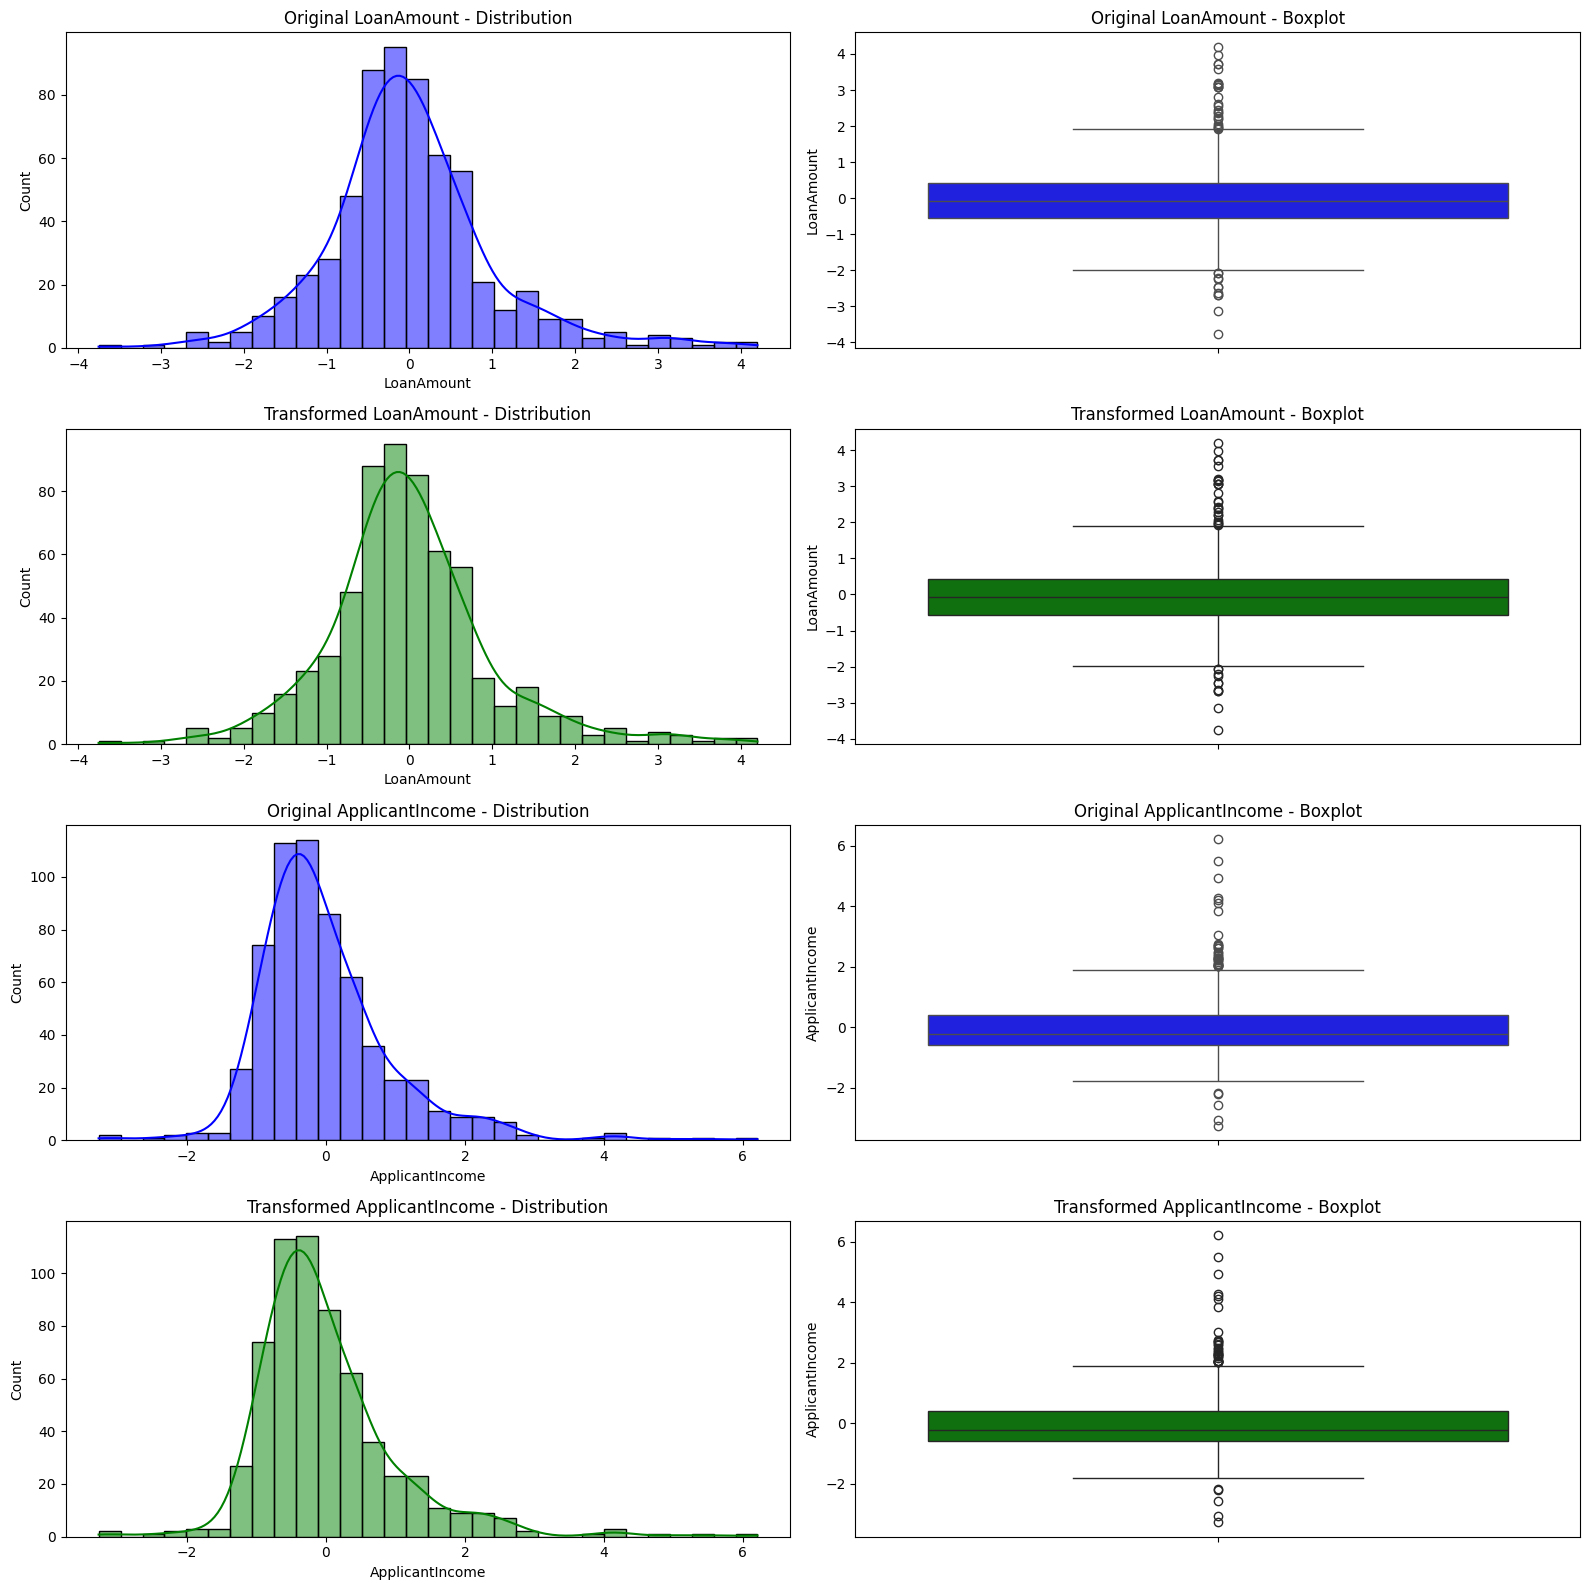

In [ ]:
# Comparison of LoanAmount and ApplicantIncome before and after transformation
plt.figure(figsize=(16, 16))

# Original LoanAmount Distribution
plt.subplot(4, 2, 1)
sns.histplot(df['LoanAmount'], kde=True, bins=30, color='blue')
plt.title('Original LoanAmount - Distribution')
plt.xlabel('LoanAmount')

# Original LoanAmount Boxplot
plt.subplot(4, 2, 2)
sns.boxplot(y=df['LoanAmount'], color='blue')
plt.title('Original LoanAmount - Boxplot')
plt.ylabel('LoanAmount')

# Transformed LoanAmount Distribution
plt.subplot(4, 2, 3)
sns.histplot(df['LoanAmount'], kde=True, bins=30, color='green')
plt.title('Transformed LoanAmount - Distribution')
plt.xlabel('LoanAmount')

# Transformed LoanAmount Boxplot
plt.subplot(4, 2, 4)
sns.boxplot(y=df['LoanAmount'], color='green')
plt.title('Transformed LoanAmount - Boxplot')
plt.ylabel('LoanAmount')

# Original ApplicantIncome Distribution
plt.subplot(4, 2, 5)
sns.histplot(df['ApplicantIncome'], kde=True, bins=30, color='blue')
plt.title('Original ApplicantIncome - Distribution')
plt.xlabel('ApplicantIncome')

# Original ApplicantIncome Boxplot
plt.subplot(4, 2, 6)
sns.boxplot(y=df['ApplicantIncome'], color='blue')
plt.title('Original ApplicantIncome - Boxplot')
plt.ylabel('ApplicantIncome')

# Transformed ApplicantIncome Distribution
plt.subplot(4, 2, 7)
sns.histplot(df['ApplicantIncome'], kde=True, bins=30, color='green')
plt.title('Transformed ApplicantIncome - Distribution')
plt.xlabel('ApplicantIncome')

# Transformed ApplicantIncome Boxplot
plt.subplot(4, 2, 8)
sns.boxplot(y=df['ApplicantIncome'], color='green')
plt.title('Transformed ApplicantIncome - Boxplot')
plt.ylabel('ApplicantIncome')

# Show the plots
plt.tight_layout()
plt.show()


```Visualizing correlations between features and the target variable```

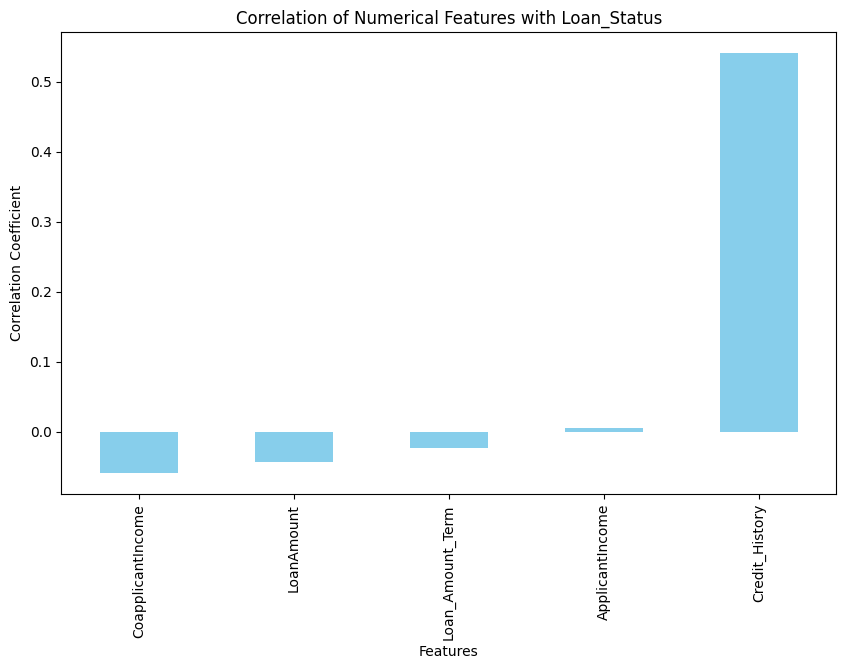

In [ ]:
correlations = df[numerical_features + ['Loan_Status']].corr()['Loan_Status'].drop('Loan_Status')

# Bar plot for numerical correlations
plt.figure(figsize=(10, 6))
correlations.sort_values().plot(kind='bar', color='skyblue')
plt.title('Correlation of Numerical Features with Loan_Status')
plt.ylabel('Correlation Coefficient')
plt.xlabel('Features')

plt.show()

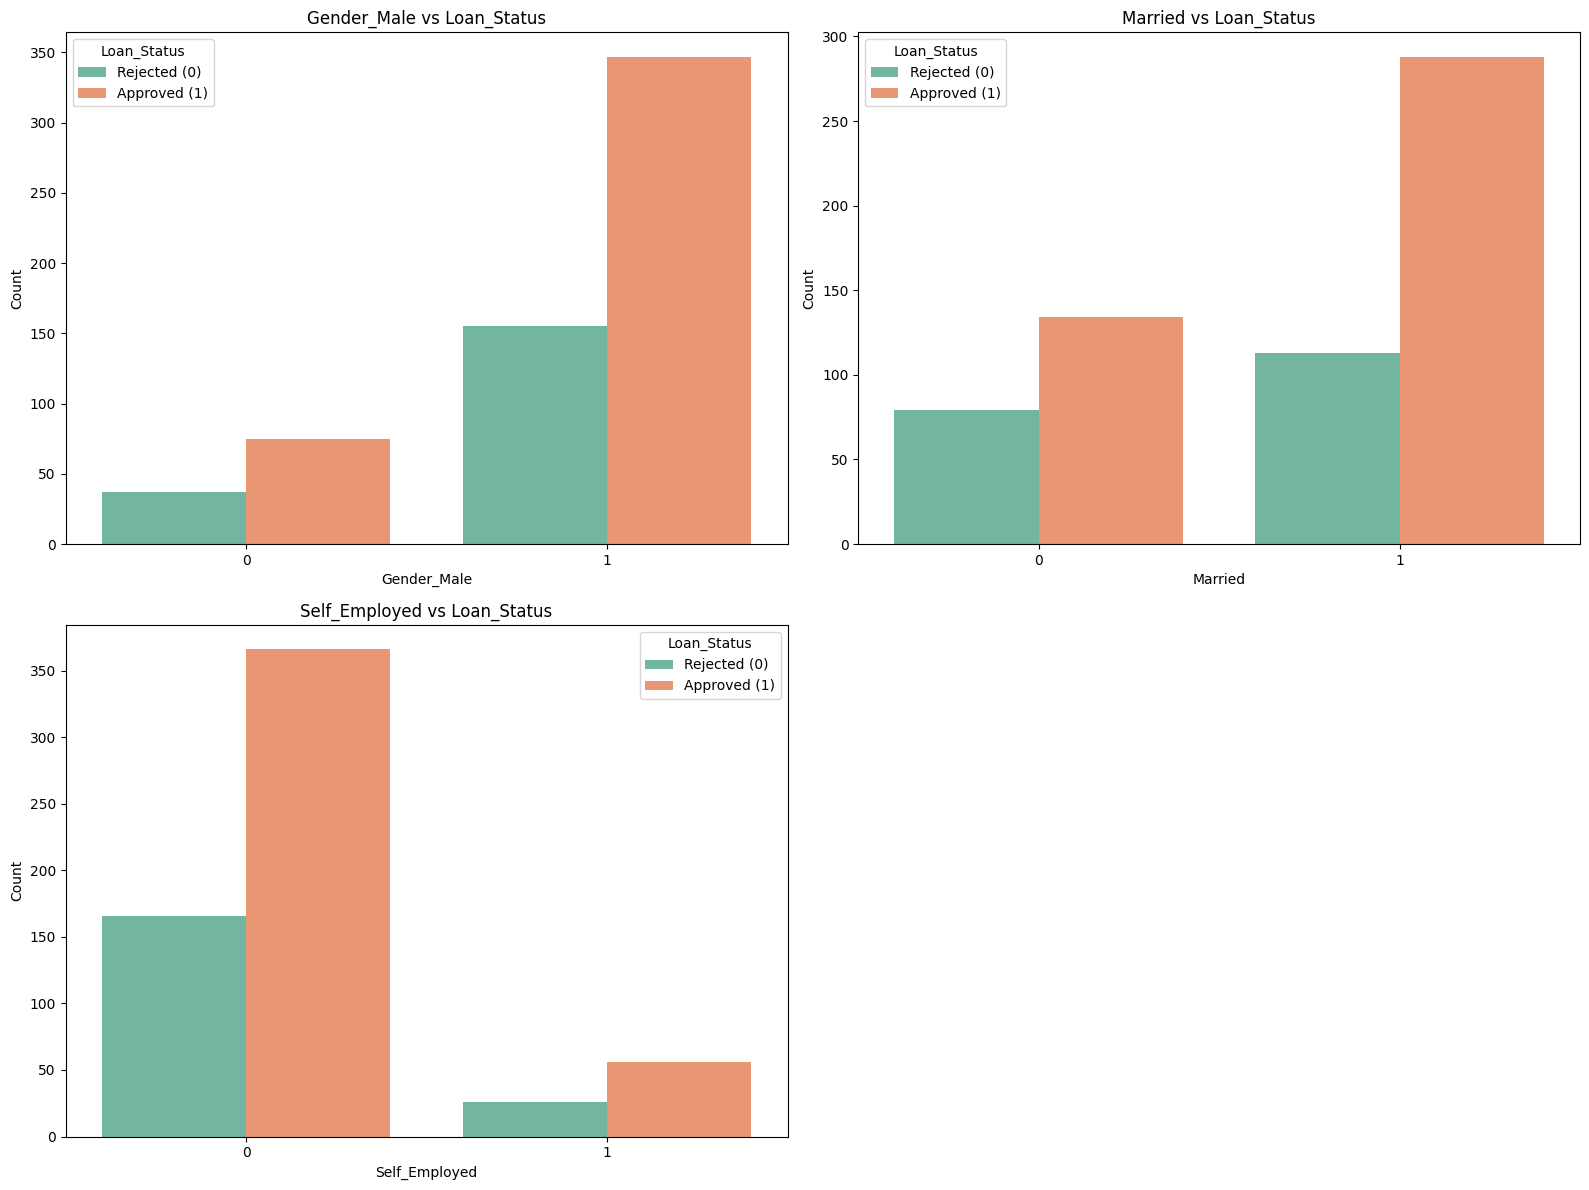

In [ ]:
import math
import matplotlib.pyplot as plt
import seaborn as sns

# Define the column names for categorical features
# Update categorical_features_names to reflect one-hot encoded columns
categorical_features_names = ['Gender_Male', 'Married', 'Self_Employed']

# Number of rows and columns for subplots
n_features = len(categorical_features_names)
rows = math.ceil(n_features / 2)  # Calculate rows dynamically for a 2-column layout

plt.figure(figsize=(16, 6 * rows))  # Adjust height based on number of rows
for i, feature in enumerate(categorical_features_names, 1):
    plt.subplot(rows, 2, i)
    sns.countplot(data=df, x=feature, hue='Loan_Status', palette='Set2')
    plt.title(f'{feature} vs Loan_Status')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.legend(title='Loan_Status', labels=['Rejected (0)', 'Approved (1)'])

plt.tight_layout()
plt.show()

In [ ]:
#Combinig applicat income and co aplicant in come ---> Total income
df['Total_Income'] = df['ApplicantIncome'] + df['CoapplicantIncome']

In [ ]:
df.drop(['ApplicantIncome','CoapplicantIncome'],axis=1,inplace=True)

In [ ]:
# Drop the Loan_ID column from the dataset
df = df.drop(columns=['Loan_ID'], errors='ignore')


```Train test Split```

In [ ]:
#train test split
X = df.drop(columns=['Loan_Status'])
y = df['Loan_Status']

In [ ]:

# Check class distribution
print("Class distribution:", Counter(y))

Class distribution: Counter({1: 422, 0: 192})


In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

```Handling the imbalanced data```

In [ ]:
X_train['Dependents'] = X_train['Dependents'].replace('3+', 3).astype(int)
X_test['Dependents'] = X_test['Dependents'].replace('3+', 3).astype(int)

for col in X_train.select_dtypes(include=['number']).columns:

    if df[col].dtype == 'Int64':
        X_train[col] = X_train[col].astype(int)
        X_test[col] = X_test[col].astype(int)

# Handle imbalanced classes using SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("Resampled class distribution:", Counter(y_train_res))

Resampled class distribution: Counter({0: 342, 1: 342})


In [ ]:
#standerdize the features
scaler = StandardScaler()
X_tarin_res = scaler.fit_transform(X_train_res)
X_test = scaler.transform(X_test)

```define the function to train and evaluate th emodel```

In [ ]:
def train_and_test(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    return accuracy, precision, recall, f1, roc_auc

In [ ]:
#Initialize the models
models={
    'Logistic Regression':LogisticRegression(random_state=42),
    'Random Forest':RandomForestClassifier(random_state=42),
    'SVM':SVC(probability=True,random_state=42),
    'XGBoost':XGBClassifier(random_state=42),
    'KNN':KNeighborsClassifier(),
    'Decision Tree':DecisionTreeClassifier(random_state=42)
}

# Initialize an empty dictionary to store the results
results = {}

# Loop to train and evaluate models
for name, model in models.items():
    print(f"Training {name}...")
    accuracy, precision, recall, f1, roc_auc = train_and_test(model, X_train_res, y_train_res, X_test, y_test)
    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    }
    print(f"{name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, ROC-AUC: {roc_auc:.4f}")

Training Logistic Regression...
Logistic Regression - Accuracy: 0.5935, Precision: 0.8000, Recall: 0.5000, F1-Score: 0.6154, ROC-AUC: 0.6831
Training Random Forest...
Random Forest - Accuracy: 0.6829, Precision: 0.7356, Recall: 0.8000, F1-Score: 0.7665, ROC-AUC: 0.6827
Training SVM...
SVM - Accuracy: 0.6341, Precision: 0.7692, Recall: 0.6250, F1-Score: 0.6897, ROC-AUC: 0.6276
Training XGBoost...
XGBoost - Accuracy: 0.6585, Precision: 0.7500, Recall: 0.7125, F1-Score: 0.7308, ROC-AUC: 0.6497
Training KNN...
KNN - Accuracy: 0.6992, Precision: 0.7654, Recall: 0.7750, F1-Score: 0.7702, ROC-AUC: 0.7411
Training Decision Tree...
Decision Tree - Accuracy: 0.6098, Precision: 0.7051, Recall: 0.6875, F1-Score: 0.6962, ROC-AUC: 0.5763


In [ ]:
import pickle

# Save the best model (KNN)
with open('best_model.pkl', 'wb') as f:
    pickle.dump(models['KNN'], f)

print("Best model (KNN) saved as 'best_model.pkl'.")

Best model (KNN) saved as 'best_model.pkl'.


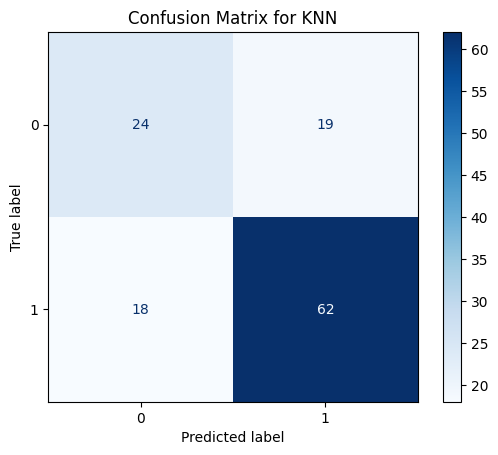

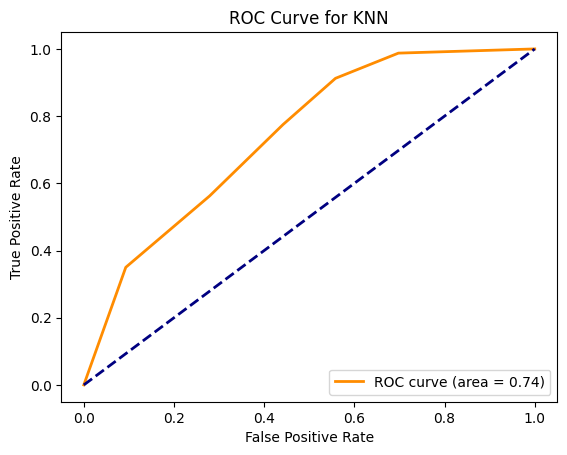

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# Confusion Matrix for KNN
y_pred = models['KNN'].predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=models['KNN'].classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for KNN")
plt.show()

# ROC Curve for KNN
y_pred_proba = models['KNN'].predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for KNN')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.svm import SVC

# Assign higher weight to class 0
class_weights = {0: 1.5, 1: 1}  # Adjust weights as needed

# Train SVM with class weights
svm_model = SVC(kernel='linear', class_weight=class_weights, probability=True, random_state=42)
svm_model.fit(X_train_res, y_train_res)

# Evaluate
y_pred = svm_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.63      0.58        43
           1       0.78      0.71      0.75        80

    accuracy                           0.68       123
   macro avg       0.66      0.67      0.66       123
weighted avg       0.70      0.68      0.69       123



In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Train KNN on the balanced dataset
knn_model = KNeighborsClassifier(n_neighbors=5)  # You can adjust n_neighbors
knn_model.fit(X_train_res, y_train_res)

# Evaluate
y_pred = knn_model.predict(X_test)
print("Classification Report for KNN with SMOTE:\n", classification_report(y_test, y_pred))

Classification Report for KNN with SMOTE:
               precision    recall  f1-score   support

           0       0.57      0.56      0.56        43
           1       0.77      0.78      0.77        80

    accuracy                           0.70       123
   macro avg       0.67      0.67      0.67       123
weighted avg       0.70      0.70      0.70       123



In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Define the parameter grid
param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}

# Initialize Grid Search
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='f1_weighted')

# Train Grid Search on the balanced dataset
grid_search.fit(X_train_res, y_train_res)

# Print the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best F1-Score:", grid_search.best_score_)

# Evaluate on the test set
y_pred = grid_search.predict(X_test)
print("Classification Report for Tuned KNN:\n", classification_report(y_test, y_pred))

Best Parameters: {'n_neighbors': 3}
Best F1-Score: 0.8040124687156727
Classification Report for Tuned KNN:
               precision    recall  f1-score   support

           0       0.59      0.53      0.56        43
           1       0.76      0.80      0.78        80

    accuracy                           0.71       123
   macro avg       0.68      0.67      0.67       123
weighted avg       0.70      0.71      0.70       123



In [ ]:
import pickle

# Save the Grid Search model to a file
with open('grid_search_model.pkl', 'wb') as f:
    pickle.dump(grid_search, f)

print("Grid Search model saved as 'grid_search_model.pkl'")

Grid Search model saved as 'grid_search_model.pkl'


In [ ]:
import pickle

# Load the Grid Search model from the file
with open('grid_search_model.pkl', 'rb') as f:
    grid_search_loaded = pickle.load(f)

print("Grid Search model loaded from 'grid_search_model.pkl'")

Grid Search model loaded from 'grid_search_model.pkl'


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Example new data (replace with actual new data)
new_data = pd.DataFrame({
    'Dependents': ['0'],
    'Married': [1],  # Encoded as 1 for 'Yes'
    'Self_Employed': [0],  # Encoded as 0 for 'No'
    'LoanAmount': [2000],
    'Loan_Amount_Term': [360],
    'Credit_History': [1],  # 1 for good credit
    'Education': [1],  # Encoded as 1 for 'Graduate'
    'Gender_Male': [1],  # 1 for Male
    'Property_Area_Semiurban': [0],  # 0 for Non-Semiurban
    'Property_Area_Urban': [1],  # 1 for Urban
    'Total_Income': [3000]
})

# Encoding categorical features if not already encoded
label_encoder = LabelEncoder()
new_data['Dependents'] = label_encoder.fit_transform(new_data['Dependents'])

# If you used scaling during training, apply the same scaling to the new data
scaler = StandardScaler()
new_data[['LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Total_Income']] = scaler.fit_transform(new_data[['LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Total_Income']])

# Predict using the trained model
# Changed grid_search_model to grid_search_loaded
prediction = grid_search_loaded.predict(new_data)

# Output the prediction
if prediction == 1:
    print("The loan is approved.")
else:
    print("The loan is rejected.")

The loan is approved.
